**Problem statement:**  
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Train dataset
# Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Validation dataset
# Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# Class names are present inside the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

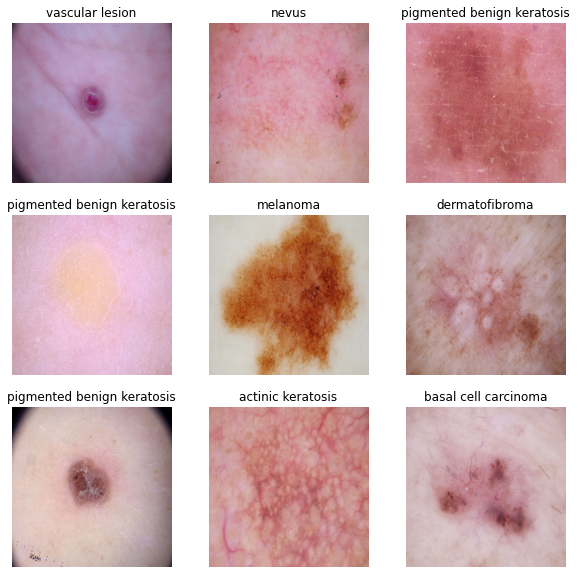

In [9]:
import matplotlib.pyplot as plt

## Use training data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
num_classes = 9

model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
# Choose an optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 572s 2s/step - loss: 2.0963 - accuracy: 0.2349 - val_loss: 1.8571 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.8247 - accuracy: 0.3432 - val_loss: 1.6313 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5216 - accuracy: 0.4609 - val_loss: 1.4723 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4146 - accuracy: 0.5028 - val_loss: 1.4353 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2739 - accuracy: 0.5508 - val_loss: 1.4453 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2074 - accuracy: 0.5737 - val_loss: 1.3583 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1570 - accuracy: 0.5932 - val_loss: 1.3666 - val_accuracy: 0.5235
Epoch 8/20
56/56 [======

### Visualizing training results

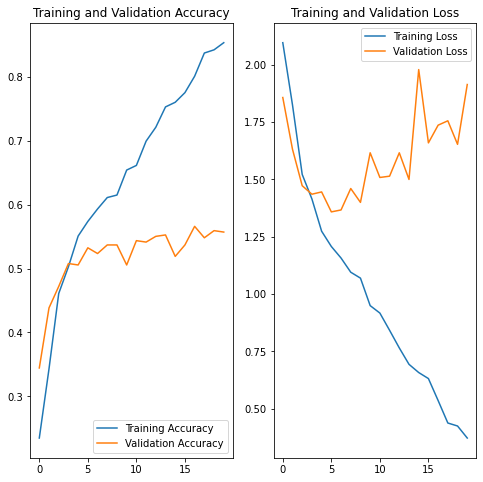

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Check the findings after the model fit to see if there is an evidence of model overfit or underfit

**Observation:**

- Training accuracy seems to increase linearly whereas Validation accuracy remains stagnant at around 55%.
- High training accuracy and low Validation accuracy is a good indicator that the model is overfit.
- To mitigate overfitting let's use data augmentation.


In [16]:
# Use data augmentation to handle overfitting
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

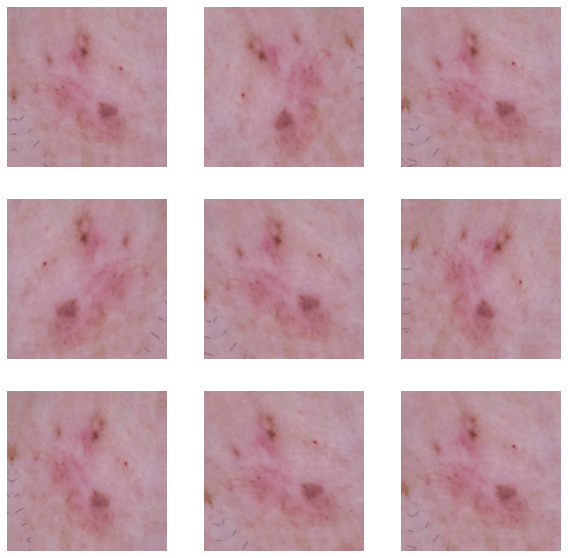

In [17]:
# Visualize how the augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [18]:
## Also use Dropout layer to prevent overfitting

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [19]:
# Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Train the model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs #epochs already initialized to 20
)

Epoch 1/20
56/56 [==============================] - 3s 44ms/step - loss: 2.0777 - accuracy: 0.2260 - val_loss: 1.9641 - val_accuracy: 0.2416
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.9032 - accuracy: 0.2846 - val_loss: 1.8901 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.7647 - accuracy: 0.3521 - val_loss: 1.6665 - val_accuracy: 0.3982
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5735 - accuracy: 0.4280 - val_loss: 2.6751 - val_accuracy: 0.3199
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5024 - accuracy: 0.4593 - val_loss: 1.4259 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3952 - accuracy: 0.4978 - val_loss: 1.3925 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3281 - accuracy: 0.5324 - val_loss: 1.3720 - val_accuracy: 0.5078
Epoch 8/20
56

### Visualizing the results

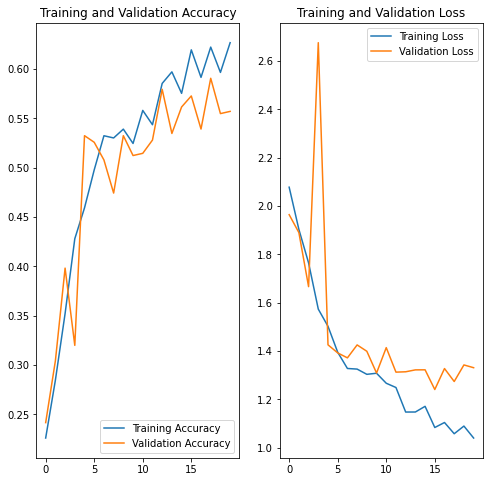

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observation:**  
- Data augmentation has brought down overfitting - the training & validation curves run close together now.
- But the accuracy has come down to below 65%.
- This could be a strong indicator of the model ___underfitting___ now - low variance but high bias.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
# List the total images under each class
from glob import glob

path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

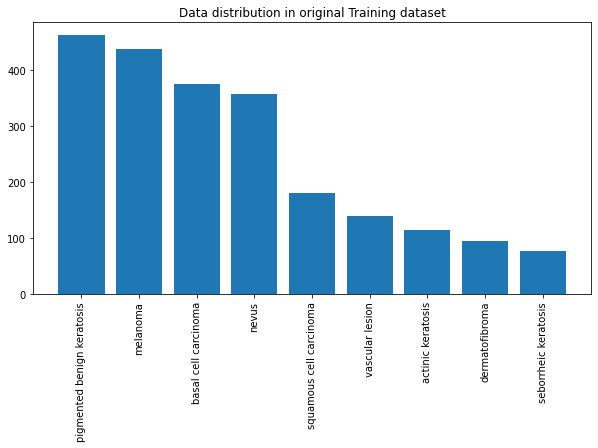

In [23]:
# Bar graph class vs total images
plt.figure(figsize=(10,5))
plt.bar(x=original_df['Label'].value_counts().index, height=original_df['Label'].value_counts().values)
plt.xticks(rotation='vertical')
plt.title('Data distribution in original Training dataset')
plt.show()

#### Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


**Observation:**  
- `seborrheic keratosis` has the lowest number of samples in the original training dataset.
- `pigmented benign keratosis` has the highest number of samples in the original training dataset followed by `melanoma` class.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A688B1E10>: 100%|██████████| 500/500 [00:20<00:00, 24.93 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B6B548FD0>: 100%|██████████| 500/500 [00:21<00:00, 23.31 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A6B805B10>: 100%|██████████| 500/500 [00:22<00:00, 22.63 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0A68845310>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F0A6B8180D0>: 100%|██████████| 500/500 [01:12<00:00,  6.88 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0A682DECD0>: 100%|██████████| 500/500 [00:17<00:00, 28.20 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0A688B1DD0>: 100%|██████████| 500/500 [00:42<00:00, 11.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A68875890>: 100%|██████████| 500/500 [00:18<00:00, 26.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A6B838210>: 100%|██████████| 500/500 [00:18<00:00, 27.25 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list_new

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [31]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [33]:
# training dataset after augmenting images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [34]:
# validation dataset after augmenting images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [35]:
# Define the model
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [36]:
# Set optimizer & evaluation metric
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [37]:
# Train the model for 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 241ms/step - loss: 2.0181 - accuracy: 0.2281 - val_loss: 1.6962 - val_accuracy: 0.3801
Epoch 2/30
169/169 [==============================] - 33s 192ms/step - loss: 1.5835 - accuracy: 0.3991 - val_loss: 1.5014 - val_accuracy: 0.4180
Epoch 3/30
169/169 [==============================] - 35s 199ms/step - loss: 1.4489 - accuracy: 0.4447 - val_loss: 1.3323 - val_accuracy: 0.4863
Epoch 4/30
169/169 [==============================] - 35s 203ms/step - loss: 1.3952 - accuracy: 0.4642 - val_loss: 1.3851 - val_accuracy: 0.4484
Epoch 5/30
169/169 [==============================] - 34s 194ms/step - loss: 1.3092 - accuracy: 0.5072 - val_loss: 1.3312 - val_accuracy: 0.4989
Epoch 6/30
169/169 [==============================] - 34s 195ms/step - loss: 1.2488 - accuracy: 0.5211 - val_loss: 1.2125 - val_accuracy: 0.5338
Epoch 7/30
169/169 [==============================] - 34s 193ms/step - loss: 1.2187 - accuracy: 0.5276 - val_loss: 1.2213 - val_ac

#### Visualize the model results

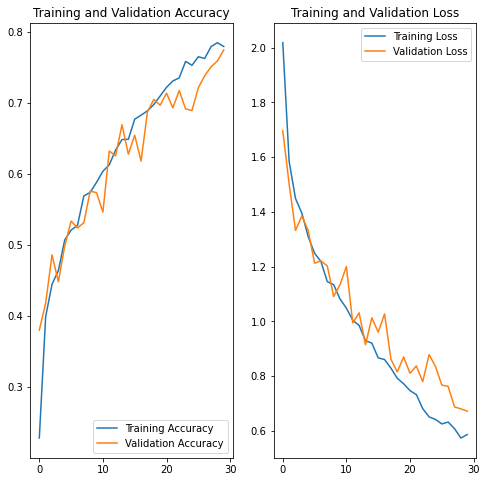

In [38]:
# Visualize the Training vs Validation accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation:**
- Training and Validation Accuracy seems to increase linearly together.
- Training accuracy touched 78% while validation accuracy runs close to 77% - this low difference indicates that the final CNN model is able to generalize well.
- This also suggets that this final model is neither overfitting nor underfitting.
- Class rebalancing has improved the model's performance.